# How to calibrate a 2D magnetometer with ellipsoid fitting

## Step 1: Load uncalibrated magnetometer data as CSV

The data was recorded by logging data from the magnetometer.

Take care! This calibration process should be done while all systems of your robot or solution are running, so in a real life environment. This will make sure we take all hard iron influences into consideration. Place the robot in the middle of a room and let your robot turn to the left and to the right for a minute, and record the data.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

rawdata = pd.read_csv('mag_out.csv')

## Step 2: Visualize the data to see what is going on

The easiest way is to plot the data on the x/y plane as a scatter plot. Every point represents a measurement of the magnetic field. We should see a perfect circle here, centered at (0,0).

Due due hard iron effects, we do not see a circle, but an ellipse. It also seems not to be centered at (0,0).

Goal of the calibration procedure is to find a way to transform the measurements back into a circle.

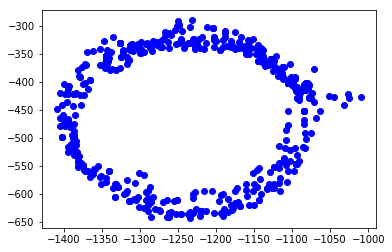

In [2]:
plt.scatter(rawdata["x"], rawdata["y"], label='Data Points', color='b')
plt.show()

## Step 3: Calculate the ellipsoid

Ellipsoid fitting tries to find the best fitting ellipsoid in the data. During this process, outliers are mostly eliminated and sensor noise reduced. As the result, we get the center point of the ellipsoid, the length of its axes and also its orientation.

In [3]:
xcol = rawdata["x"]
ycol = rawdata["y"]

xmin = xcol.min()
xmax = xcol.max()

ymin = ycol.min()
ymax = ycol.max()

width = xmax - xmin
height = ymax - ymin
xyratio = width / height

# Code taken from https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/
def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi

coeffs = fit_ellipse(xcol, ycol)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)

rat = ap / bp

[rat, width, height, x0, y0, ap, bp, e, math.degrees(phi)]

[1.0796413093991812,
 400.20000000000005,
 353.28000000000003,
 -1233.4002215714197,
 -470.0750665204955,
 163.20561363912586,
 151.1665144879919,
 0.37695014994169934,
 4.989293694051862]

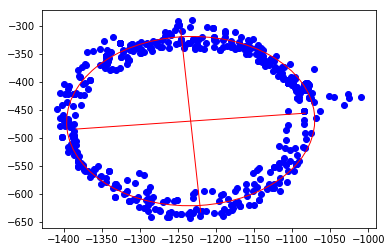

In [4]:
ellipse = Ellipse((x0, y0), ap * 2, bp * 2, color='r', angle=math.degrees(phi), fill=False)

fig, ax = plt.subplots()
ax.add_patch(ellipse)
ax.scatter(xcol, ycol, label='Data Points', color='b')

plt.plot([x0 - math.cos(phi) * bp, x0 + math.cos(phi) * bp], [y0  - math.sin(phi) * ap, y0 + math.sin(phi) * ap], color='r', linestyle='-', linewidth=1)
plt.plot([x0 - math.cos(phi + math.pi / 2) * bp, x0 + math.cos(phi + math.pi / 2) * bp], [y0 - math.sin(phi + math.pi / 2) * ap, y0 + math.sin(phi + math.pi / 2) * ap], color='r', linestyle='-', linewidth=1)

plt.show()

## Step 4: Apply offsets and rotation to data

We apply the found hard iron offsets, scale factors and rotation compensations to the data points to make it the best circle we can.

In [5]:
rot = round(phi / (math.pi / 2.0))
rotation = -(phi - rot * math.pi / 2.0)

def correctdata(row):
    x = row["x"] - x0
    y = row["y"] - y0
    return [x * np.cos(rotation) - y * np.sin(rotation),
            (x * np.sin(rotation) + y * np.cos(rotation)) * rat]

res = rawdata.apply(correctdata, axis=1, result_type='expand')
rawdata["xcorrected"] = res[0]
rawdata["ycorrected"] = res[1]

math.degrees(phi), math.degrees(rotation)

(4.989293694051862, -4.989293694051862)

## Finally, the corrected data

Here we are, this is the result when the calibration is applied. The center of the circle is at (0,0). There is also a green circle in the background showing the layout of a perfect circle to see the difference.

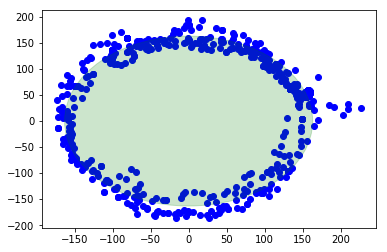

In [6]:
circle = plt.Circle((0, 0), ap, color='g', alpha=0.2)

fig, ax = plt.subplots()
ax.add_patch(circle)
ax.scatter(rawdata["xcorrected"], rawdata["ycorrected"], label='Data Points', color='b')

plt.show()

# Summary

## Pros

- Sensor noise and outliers are well handled
- Directional and rotational offsets are corrected
- Works with a small set of data points to start calibration

## Cons

- Computationally intensive
- Harder math
- Harder to debug